In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn.preprocessing as preproc
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn import metrics

from sklearn.model_selection import train_test_split

2024-04-08 19:57:56.484524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 19:57:56.666298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-08 19:57:56.666340: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-08 19:57:56.701644: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 19:57:57.433128: W tensorflow/stream_executor/pla

In [2]:
complaints = pd.read_csv('complaints_25Nov21.csv')
#complaints = pd.get_dummies(df)
complaints.head()

,Product,Sub-product,Issue,Sub-issue,State,Tags,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
0,Money transfers,International money transfer,Other transaction issues,NaN,NaN,NaN,Consent provided,Web,Closed with explanation,Yes,No
1,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,PA,Older American,Consent provided,Web,Closed with explanation,Yes,No
2,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,PA,NaN,Consent provided,Web,Closed with monetary relief,Yes,No
3,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,VA,Servicemember,NaN,Phone,Closed with explanation,Yes,Yes
4,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,GA,NaN,NaN,Referral,Closed with explanation,Yes,No


In [4]:
#2.	Set your X (predictor) and y (predicted) variables.  
categorical_columns = ['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']
# Performing one-hot encoding
X = pd.get_dummies(complaints[categorical_columns])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(complaints['Consumer disputed?'])

In [5]:
#3.	Split your data into a test and train set.  Use an 80/20 train-test split, and random_state=123 for the train-test split. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
y_test.mean()

0.21586413200810575

In [6]:
# Check the proportion of complaints in your training dataset are disputed
from imblearn.under_sampling import RandomUnderSampler
disputed_proportion = y_train.mean()
if disputed_proportion < 0.3:
    # Use random undersampling to balance the dataset
    undersampler = RandomUnderSampler(random_state=123)
    X_train, y_train = undersampler.fit_resample(X, y)
y_train.mean()

0.5

In [24]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [26]:
# Calculate the total cost to the banks of dealing with the complaints in the test set without a model

# Given costs
base_cost_per_complaint = 100  # Cost to resolve every complaint
additional_dispute_cost = 500  # Additional cost if the complaint is disputed

# Total base cost for all complaints
total_base_cost = len(y_test) * base_cost_per_complaint

# Additional cost for disputed complaints
# We calculate the number of disputed complaints by summing up the '1's in y_test
total_disputed_complaints = y_test.sum()
total_additional_dispute_cost = total_disputed_complaints * additional_dispute_cost

# Total cost is the sum of base cost and additional dispute cost
total_cost_no_model = total_base_cost + total_additional_dispute_cost
total_cost_no_model

8619200

In [40]:
from xgboost import XGBClassifier
disputed_proportion = y_train.mean()
if disputed_proportion < 0.3:
    # Use random undersampling to balance the dataset
    undersampler = RandomUnderSampler(random_state=123)
    X_train, y_train = undersampler.fit_resample(X_train, y_train)

# Predict on the test set
y_pred = model_xgb.predict(X_test)

# Generate and print classification report
report = classification_report(y_test, y_pred, target_names=['No','Yes'])

              precision    recall  f1-score   support

          No       0.85      0.53      0.66     32504
         Yes       0.28      0.66      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.57      0.60      0.52     41452
weighted avg       0.73      0.56      0.60     41452



              precision    recall  f1-score   support

           0       0.85      0.53      0.66     32504
           1       0.28      0.66      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.57      0.60      0.52     41452
weighted avg       0.73      0.56      0.60     41452



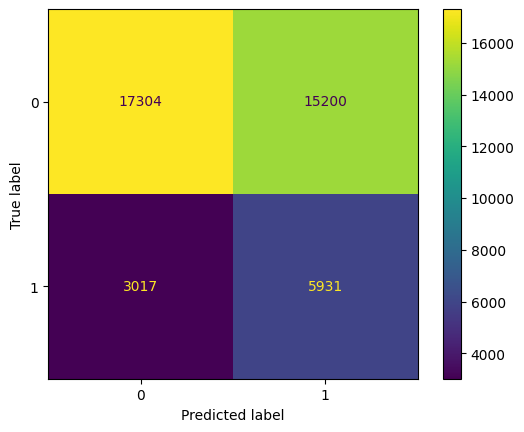

In [41]:
pred_prob = model_xgb.predict(X_test)
threshold = 0.5
pred = (model_xgb.predict(X_test)>threshold) * 1
print(classification_report(y_true = y_test, y_pred = pred))
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [42]:
from sklearn.metrics import confusion_matrix

# Assuming y_test contains the true labels from your test set
# Assuming y_pred contains the predicted labels from your XGBoost model

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define the cost values
cost_tp_fp = 190  # Cost for true positives and false positives (extra diligence)
cost_fn = 600  # Cost for false negatives (missed disputes)
cost_tn = 100  # Baseline cost for true negatives (non-disputed complaints)

# Calculate the total cost based on model results
total_cost_model = (tp + fp) * cost_tp_fp + fn * cost_fn + tn * cost_tn

print(f"Total cost based on model results: ${total_cost_model}")


Total cost based on model results: $7555490


In [45]:
best_threshold = 0.5
lowest_total_cost = float('inf')

# Iterate over a range of possible thresholds
for threshold in np.linspace(0, 1, 101):
    # Determine predicted labels based on the threshold
    predictions = (probabilities >= threshold).astype(int)
    
    # Calculate the confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
    
    # Calculate the costs based on predictions
    base_costs = len(y_test) * 100
    due_diligence_costs = (FP + TP) * 90
    disputed_costs = FN * 500
    
    # Total cost with the current threshold
    total_cost = base_costs + due_diligence_costs + disputed_costs
    
    # If the current total cost is lower than the previous lowest, update the best threshold and lowest cost
    if total_cost < lowest_total_cost:
        lowest_total_cost = total_cost
        best_threshold = threshold

# After finding the best threshold and lowest total cost
print(f"The lowest total cost of ${lowest_total_cost} is achieved at a threshold of {best_threshold}.")

The lowest total cost of $7488580 is achieved at a threshold of 0.46.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2b0742f-f778-4b54-aa29-380febfb2638' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>